<a href="https://www.kaggle.com/code/syerramilli/home-credit-baseline-polars-lightgbm?scriptVersionId=177079370" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

## Introduction

In this notebook, we will be building a basline model for the Home Credit Kaggle competition. The goal of this competition is to predict the probability of a client defaulting on a loan. Since the dataset is quite large, we will be using Polars to load and process the data. 


**CHANGELOG**:

v4 -> v5:
Re-running on modified dataset.

v3 -> v4:
1. Added min and mean as aggregate statistics in addition to max for tables with depth >= 1
2. Added a preliminary EDA section. 


In [1]:
import os
import gc
from glob import glob
from pathlib import Path

import numpy as np
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns


import lightgbm as lgb
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedGroupKFold

from typing import List

plt.style.use('ggplot')
plt.rcParams.update({'figure.dpi':150})

## Loading the data


1. We will be using the parquet files provided by the competition. The parquet files are stored in the `parquet_files` directory. The `train` and `test` directories contain the training and testing data, respectively. 
2. We use the Lazy API to read the parquet files using `scan_parquet`. This allows for efficient reading of the data and also allows us to perform operations on the data without loading it into memory until necessary. 

In [2]:
TRAIN_DIR = Path('/kaggle/input/home-credit-credit-risk-model-stability/parquet_files/train/')
TEST_DIR = Path('/kaggle/input/home-credit-credit-risk-model-stability/parquet_files/test/')

In [3]:
def correct_dtypes(df: pl.LazyFrame) -> pl.LazyFrame:
    for column in df.columns:
        if column in {'case_id', 'WEEK_NUM', 'num_group1', 'num_group2'}:
            df = df.with_columns(pl.col(column).cast(pl.Int64))
        elif column == 'date_decision' or column[-1] == 'D':
            df = df.with_columns(pl.col(column).cast(pl.Date))
        elif column[-1] in {'A', 'P'}:
            df = df.with_columns(pl.col(column).cast(pl.Float64))
        elif column[-1] == 'M':
            df = df.with_columns(pl.col(column).cast(pl.String))
        
    return df    


def aggregate_exprs(df: pl.LazyFrame) -> List:
    '''
    Create aggregate expressions for tables with depth > 1. The
    actual aggreation is done elsewhere following a groupby statement.

    TODO: Currently only supports max aggregation. Add more expressions.
    '''
    
    exprs = []
    for column in df.columns:
        if column[-1] in {'D', 'A', 'P'}:
            # dates or numerical
            exprs += [
                pl.max(column).alias(f'max_{column}'),
                pl.min(column).alias(f'min_{column}'),
                pl.mean(column).alias(f'mean_{column}')
            ]
        # TODO: add more expressions
    
    return exprs


def read_file(path, depth:int=None) -> pl.LazyFrame:
    '''
    Read a parquet file and return a polars dataframe. If depth >= 1,
    then the dataframe is grouped by case_id and aggregated.
    '''
    df = pl.scan_parquet(path).pipe(correct_dtypes)
    
    if depth in {1, 2}:
        df = df.group_by('case_id').agg(aggregate_exprs(df))
    
    return df

def read_files(regex_path, depth:int=None) -> pl.LazyFrame:
    '''
    Read all parquet files matching the regex pattern and 
    concatenate them into a single dataframe. If depth >= 1,
    then the dataframe is grouped by case_id and aggregated.
    '''

    chunks = []
    for path in glob(str(regex_path)):
        chunks.append(
            pl.scan_parquet(path).pipe(correct_dtypes)
        )

    df = pl.concat(chunks, how='vertical_relaxed')
    if depth in {1, 2}:
        df = df.group_by('case_id').agg(aggregate_exprs(df))
    
    return df

In [4]:
# Credit: https://www.kaggle.com/code/greysky/home-credit-baseline
data_stores = {
    "df_base": read_file(TRAIN_DIR / "train_base.parquet"),
    "other_dfs": [
        # depth 0
        read_file(TRAIN_DIR / "train_static_cb_0.parquet"),
        read_files(TRAIN_DIR / "train_static_0_*.parquet"),
        # depth 1
        read_files(TRAIN_DIR / "train_applprev_1_*.parquet", 1),
        read_file(TRAIN_DIR / "train_tax_registry_a_1.parquet", 1),
        read_file(TRAIN_DIR / "train_tax_registry_b_1.parquet", 1),
        read_file(TRAIN_DIR / "train_tax_registry_c_1.parquet", 1),
        read_file(TRAIN_DIR / "train_credit_bureau_b_1.parquet", 1),
        read_file(TRAIN_DIR / "train_other_1.parquet", 1),
        read_file(TRAIN_DIR / "train_person_1.parquet", 1),
        read_file(TRAIN_DIR / "train_deposit_1.parquet", 1),
        read_file(TRAIN_DIR / "train_debitcard_1.parquet", 1),
        # depth 2
        read_file(TRAIN_DIR / "train_credit_bureau_b_2.parquet", 2),
    ]
}

We will now merge the dataframes to create one full training set. 

In [5]:
def datediff_col_exprs(date_columns):
    exprs = []
    for column in date_columns:
        exprs.append(
            (pl.col(column) - pl.col('date_decision')).dt.total_days().alias(f'days_from_decision_{column}')
        )
    
    return exprs

def merge_and_basic_fe(df_base, other_dfs:List[pl.LazyFrame]):
    '''
    Combine the data and add some preliminary feature engineering
    '''
    
    # add month and weekday columns for decision dates
    df_base = (
        df_base
        # the MONTH seems to the same as date_decision without delimiters
        .drop('MONTH') 
        .with_columns(
            MONTH_NUM=pl.col('date_decision').dt.month(),
            WEEKDAY_NUM=pl.col('date_decision').dt.weekday(),
        )
    )

    # merge the other dataframes
    for i, df in enumerate(other_dfs):
        df_base = df_base.join(df, on='case_id', how='left', suffix=f'_{i}')
    
    # Create a new column for each date column that represents the number of 
    # days from the decision date. The orginal date column is then dropped.
    schema = df_base.schema
    date_columns = [column for column in schema if schema[column] == pl.Date]
    df_base = (
        df_base
        .with_columns(datediff_col_exprs(date_columns))
        .drop(date_columns)
        .drop('date_decision')
    )
    
    return df_base.with_columns(pl.col('opencred_647L').cast(pl.Int32))

In [6]:
df_train = merge_and_basic_fe(**data_stores)
schema = df_train.schema
print(f'Number of columns........: {len(schema)}')

Number of columns........: 429


In [7]:
# We haven't actually run anything until this step
# We need to read in the data to calculate the number of observations
# With Lazy API, polars will optimize the amount of data read into memory
num_obs = df_train.select(pl.len()).collect(streaming=True).item()

print(f'Number of observations...: {num_obs}')

Number of observations...: 1526659


We will drop columns with missing values.

In [8]:
# 1. Compute the number of missing values in each column and compute the percentages
# this op takes time to compute since we need to actually perform
# operations on the entire training set
missing_perc = df_train.null_count().collect(streaming=True) / num_obs * 100

# 2. Get a list of all columns with missing value percentages greater than 50%
columns_to_drop = [col for col in missing_perc.columns if missing_perc[col][0] > 50]
print(f'Number of colums with > 50% missing values: {len(columns_to_drop)}')

# 3. Drop these columns from the training set
df_train = df_train.drop(columns_to_drop)
schema = df_train.schema
print(f'Number of columns after dropping: {len(schema)}')

Number of colums with > 50% missing values: 235
Number of columns after dropping: 194


There are some columns which are categorical. We will drop columns that have only 1 unique value or have way too many unique values

In [9]:
cat_columns_to_drop = []
for column in schema:
    if schema[column] == pl.String:
        # get frequency 
        freq = df_train.select(column).unique().select(pl.len()).collect(streaming=True).item()
        
        if freq == 1 or freq > 20:
            cat_columns_to_drop.append(column)

# drop these columns
df_train = df_train.drop(cat_columns_to_drop)

schema = df_train.schema
print(f'Number of columns after dropping: {len(schema)}')

Number of columns after dropping: 188


## EDA

The goal of the classification task is to predict the probability of a client defaulting on a loan. We will start by looking at the distribution of the target variable. There is a severe class imbalance in the target variable, with the majority class being the non-default class with about a 97% share of the data. 

In [10]:
target_dist = (
    df_train
    .group_by('target')
    .agg(pl.count('target').alias('count'))
    .collect(streaming=True)
    .with_columns(
        percentage = pl.col('count') / pl.col('count').sum() * 100
    )
    .to_pandas()
    .set_index('target')
)
target_dist

,count,percentage
target,,
1,47994,3.143728
0,1478665,96.856272


By week number, we can see that the overall default rate in the training data fluctuates around 3% with some weeks having a default rate of 5% or more. There is no clear trend in the default rate over time. 

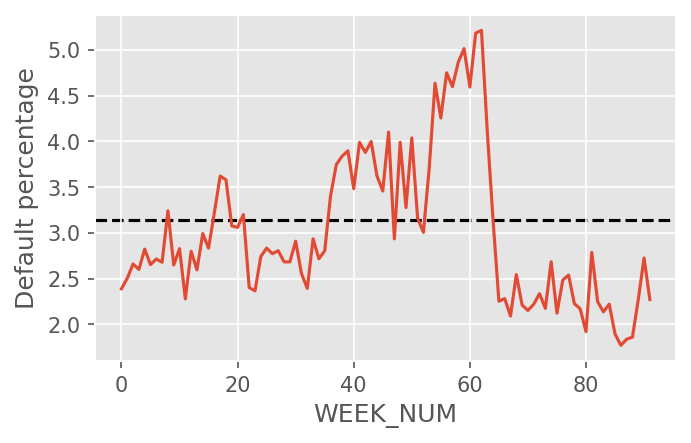

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
(
    df_train
    .group_by('WEEK_NUM')
    .agg(pl.mean('target') * 100)
    .collect()
    .sort(by='WEEK_NUM')
    .to_pandas()
    .plot(kind='line', x='WEEK_NUM', y='target', ax=ax, legend=False)
)

_ = ax.axhline(y=target_dist.loc[1, 'percentage'], color='k', linestyle='--', zorder=0)
_ = ax.set_ylabel('Default percentage')

The number of queries to the credit bureau seems to have a positive relationship with the default rate. The default rate increases as the number of queries increases.

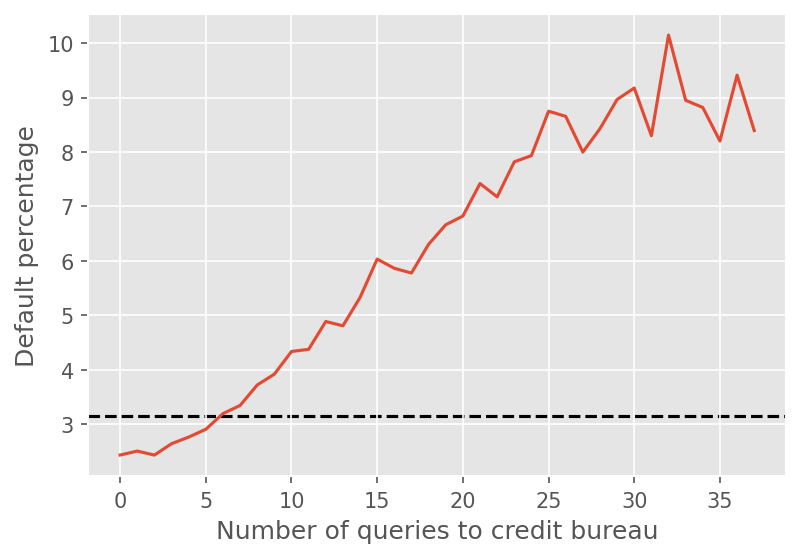

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
(
    df_train
    .group_by('numberofqueries_373L')
    .agg(default_perc = pl.mean('target') * 100, n_obs = pl.len())
    .collect(streaming=True)
    .filter(pl.col('n_obs') > 250)
    .sort(by='numberofqueries_373L')
    .to_pandas()
    .plot(kind='line', x='numberofqueries_373L', y='default_perc', ax=ax, legend=False)
)

_ = ax.axhline(y=target_dist.loc[1, 'percentage'], color='k', linestyle='--', zorder=0)
_ = ax.set_ylabel('Default percentage')
_ = ax.set_xlabel('Number of queries to credit bureau')

Note that in the plot above, we filtered out the number of queries that have less than 250 observations. All the filtered out cases have the number of queries > 37 (which is a lot).  Including these observations made the plot unreadable as there was too much noise - in some cases there were only 1 or 2 observations and these are likely to be outliers. To handle this, we will clip the number of queries at 38.

In [13]:
df_train = df_train.with_columns(
    numberofqueries_373L = (
        pl.when(pl.col('numberofqueries_373L') > 38).then(38)
        .otherwise(pl.col('numberofqueries_373L'))
    )
)

## Convert to pandas

We will convert the polars LazyFrame to a pandas DataFrame. As far as I know, lightgbm cannot directly process polars dataframes as of yet. Since some of the columns are categorical, we might need additional type processing for these columns

In [14]:
categorical_cols = [column for column in schema if schema[column] == pl.String]
# expensive step: since 
df_train = df_train.collect().to_pandas()
df_train[categorical_cols] = df_train[categorical_cols].astype('category')

In [15]:
# garbage collection
del data_stores

_ = gc.collect()

In [16]:
# inspect pandas dataframe
df_train.head()

,case_id,WEEK_NUM,target,MONTH_NUM,WEEKDAY_NUM,days120_123L,days180_256L,days30_165L,days360_512L,days90_310L,...,days_from_decision_mean_dtlastpmtallstes_3545839D,days_from_decision_max_employedfrom_700D,days_from_decision_min_employedfrom_700D,days_from_decision_mean_employedfrom_700D,days_from_decision_max_firstnonzeroinstldate_307D,days_from_decision_min_firstnonzeroinstldate_307D,days_from_decision_mean_firstnonzeroinstldate_307D,days_from_decision_max_birth_259D,days_from_decision_min_birth_259D,days_from_decision_mean_birth_259D
0,0,0,0,1,4,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-11874,-11874,-11874
1,1,0,0,1,4,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-22435,-22435,-22435
2,2,0,0,1,5,NaN,NaN,NaN,NaN,NaN,...,NaN,-3245.0,-3245.0,-3245.0,-2071.0,-2071.0,-2071.0,-16105,-16105,-16105
3,3,0,0,1,4,NaN,NaN,NaN,NaN,NaN,...,NaN,-233.0,-233.0,-233.0,35.0,35.0,35.0,-9286,-9286,-9286
4,4,0,1,1,5,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,35.0,35.0,35.0,-9134,-9134,-9134


## Lightgbm Model

Credit: https://www.kaggle.com/code/greysky/home-credit-baseline

In [17]:
X = df_train.drop(columns=["target", "case_id", "WEEK_NUM"])
y = df_train["target"]
weeks = df_train["WEEK_NUM"]

cv = StratifiedGroupKFold(n_splits=5, shuffle=False)

params = {
    "boosting_type": "gbdt",
    "objective": "binary",
    "metric": "auc",
    "max_depth": 10,
    "learning_rate": 0.05,
    "n_estimators": 1000,
    "colsample_bytree": 0.8, 
    "colsample_bynode": 0.8,
    "verbose": -1,
    "random_state": 42,
    "device": "gpu",
}

fitted_models = []

for idx_train, idx_valid in cv.split(X, y, groups=weeks):
    X_train, y_train = X.iloc[idx_train], y.iloc[idx_train]
    X_valid, y_valid = X.iloc[idx_valid], y.iloc[idx_valid]

    model = lgb.LGBMClassifier(**params)
    model.fit(
        X_train, y_train,
        eval_set=[(X_valid, y_valid)],
        callbacks=[lgb.log_evaluation(100), lgb.early_stopping(50)]
    )

    fitted_models.append(model)


1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.


Training until validation scores don't improve for 50 rounds
[100]	valid_0's auc: 0.799876
[200]	valid_0's auc: 0.806692
[300]	valid_0's auc: 0.808213
[400]	valid_0's auc: 0.809011
[500]	valid_0's auc: 0.809355
[600]	valid_0's auc: 0.809733
[700]	valid_0's auc: 0.810031
[800]	valid_0's auc: 0.810176
[900]	valid_0's auc: 0.810303
Early stopping, best iteration is:
[855]	valid_0's auc: 0.810347
Training until validation scores don't improve for 50 rounds
[100]	valid_0's auc: 0.800587
[200]	valid_0's auc: 0.806817
[300]	valid_0's auc: 0.808706
[400]	valid_0's auc: 0.809599
[500]	valid_0's auc: 0.810083
[600]	valid_0's auc: 0.81062
[700]	valid_0's auc: 0.810882
[800]	valid_0's auc: 0.81118
Early stopping, best iteration is:
[821]	valid_0's auc: 0.811347
Training until validation scores don't improve for 50 rounds
[100]	valid_0's auc: 0.803364
[200]	valid_0's auc: 0.810699
[300]	valid_0's auc: 0.812865
[400]	valid_0's auc: 0.813435
[500]	valid_0's auc: 0.813995
[600]	valid_0's auc: 0.814574

In [18]:
# save fitted models
import joblib
joblib.dump(fitted_models, 'lgbm_fitted.pkl')

['lgbm_fitted.pkl']

# Submission

In [19]:
# Credit: https://www.kaggle.com/code/greysky/home-credit-baseline
data_stores = {
    "df_base": read_file(TEST_DIR / "test_base.parquet"),
    "other_dfs": [
        # depth 0
        read_file(TEST_DIR / "test_static_cb_0.parquet"),
        read_files(TEST_DIR / "test_static_0_*.parquet"),
        # depth 1
        read_files(TEST_DIR / "test_applprev_1_*.parquet", 1),
        read_file(TEST_DIR / "test_tax_registry_a_1.parquet", 1),
        read_file(TEST_DIR / "test_tax_registry_b_1.parquet", 1),
        read_file(TEST_DIR / "test_tax_registry_c_1.parquet", 1),
        read_file(TEST_DIR / "test_credit_bureau_b_1.parquet", 1),
        read_file(TEST_DIR / "test_other_1.parquet", 1),
        read_file(TEST_DIR / "test_person_1.parquet", 1),
        read_file(TEST_DIR / "test_deposit_1.parquet", 1),
        read_file(TEST_DIR / "test_debitcard_1.parquet", 1),
        # depth 2
        read_file(TEST_DIR / "test_credit_bureau_b_2.parquet", 2),
    ]
}


# process test set in appropriate formate
df_test = (
    merge_and_basic_fe(**data_stores)
    .drop(columns_to_drop) # drop columns with too many missing values
    .drop(cat_columns_to_drop) # drop columns with too many categorical values
    .with_columns(
        numberofqueries_373L = (
            pl.when(pl.col('numberofqueries_373L') > 38).then(38)
            .otherwise(pl.col('numberofqueries_373L'))
        )
    )
    .collect().to_pandas()
    .set_index('case_id')
    .drop(columns=['WEEK_NUM'])
)

df_test[categorical_cols] = df_test[categorical_cols].astype("category")

In [20]:
# generate predictions (avgd probabilities)
prob_preds = np.column_stack([
    model.predict_proba(df_test)[:, 1] for model in fitted_models
]).mean(axis=1)

submission = pd.DataFrame({
    'case_id': df_test.index.tolist(),
    'score': prob_preds
})

submission.to_csv('submission.csv', index=None)